# Chest X-Ray Scans Pneumonia Identification

This notebook uses a simple CNN.

First, we import all the needed dependencies

In [1]:
import numpy as np # linear algebra
import tensorflow as tf
import keras
import os
import shutil
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import confusion_matrix
import skimage
from skimage import exposure
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.


# Load and View Data

In [2]:
image_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

The images that are originally present aren't very clear. They have very low contrast. So, we use a combination of Adaptive Histogram Equalization and standard Histogram Equalization on all images

In [3]:
def histEquali(img):
    img = (img).astype(int).astype(np.uint16)
#     print(img.shape,img.dtype)
    op = exposure.equalize_hist(exposure.equalize_adapthist(img.reshape(img.shape[0],img.shape[1]))).reshape(img.shape[0],img.shape[1],1)
#     print(img.shape,img.dtype)
    return op

In [4]:
def load_data(image_dir):
    images = []
    y = []
    label_dict = {}
    classNum = 0
    for class1 in tqdm(sorted(os.listdir(image_dir))):
        for file_name in os.listdir(os.path.join(image_dir,class1)):
            img = cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(image_dir,class1,file_name)),cv2.COLOR_BGR2GRAY),(224,224))
            img = histEquali(img)
            images.append(img / 255.)
            y.append(classNum)
        label_dict[classNum] = class1
        classNum += 1
    print(f'Loaded {len(images)} images from {image_dir} directory')
    images = np.array(images)
    images = images.reshape(-1,224,224,1)
    y = np.array(y)
    return images,y,label_dict

In [5]:
def show_samples(X,y,label_dict,n=20):
    for class1 in label_dict.keys():
        imgs = X[y == class1][:n]
        j = 10
        i = n // 10
        plt.figure(figsize=(15,3))
        for (c,img) in enumerate(imgs,1):
            plt.subplot(i,j,c)
            plt.imshow(img.reshape(224,224), cmap='gray')
            plt.xticks([])
            plt.yticks([])
        plt.suptitle(f'Tumor: {label_dict[class1]}')

We load all the images in our RAM

In [6]:
train_images, train_labels,label_dict = load_data(image_dir+'train/')
val_images, val_labels,_ = load_data(image_dir+'val/')
test_images, test_labels,_ = load_data(image_dir+'test/')

train_images[0].shape, val_images[0].shape, test_images[0].shape, label_dict

100%|██████████| 2/2 [03:02<00:00, 91.11s/it]


Loaded 5216 images from /kaggle/input/chest-xray-pneumonia/chest_xray/train/ directory


  0%|          | 0/2 [00:00<?, ?it/s]

Loaded 16 images from /kaggle/input/chest-xray-pneumonia/chest_xray/val/ directory


100%|██████████| 2/2 [00:21<00:00, 10.51s/it]

Loaded 624 images from /kaggle/input/chest-xray-pneumonia/chest_xray/test/ directory


((224, 224, 1), (224, 224, 1), (224, 224, 1), {0: 'NORMAL', 1: 'PNEUMONIA'})

In [7]:
np.unique(train_labels,return_counts=True), np.unique(val_labels,return_counts=True), np.unique(test_labels,return_counts=True)

((array([0, 1]), array([1341, 3875])),
 (array([0, 1]), array([8, 8])),
 (array([0, 1]), array([234, 390])))

# View Data in Train, Test, Validation Sets

While training the model using these datasets, I was not getting a good accuracy. So, I decided to concatenate all the datasets and from this master dataset, randomly create train, validation, test splits

In [8]:
img_dataset = np.concatenate([train_images,test_images,val_images],axis=0)
img_labels = np.concatenate([train_labels,test_labels,val_labels],axis=0)

shuffler = np.random.permutation(len(img_dataset))
img_dataset = img_dataset[shuffler]
img_labels = img_labels[shuffler]

In [9]:
train_s = int(0.9 * len(img_dataset))
val_s = int(0.05 * len(img_dataset))
test_s = int(0.05 * len(img_dataset))

train_images = img_dataset[:train_s,:]
train_labels = img_labels[:train_s]

val_images = img_dataset[train_s:train_s+val_s,:]
val_labels = img_labels[train_s:train_s+val_s]

test_images = img_dataset[train_s+val_s:,:]
test_labels = img_labels[train_s+val_s:]

We can see that the distribution of classes in all 3 datasets is fairly similar

In [10]:
np.unique(train_labels,return_counts=True), np.unique(val_labels,return_counts=True), np.unique(test_labels,return_counts=True)

((array([0, 1]), array([1444, 3826])),
 (array([0, 1]), array([ 61, 231])),
 (array([0, 1]), array([ 78, 216])))

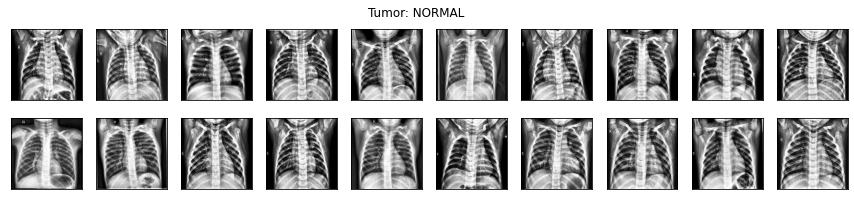

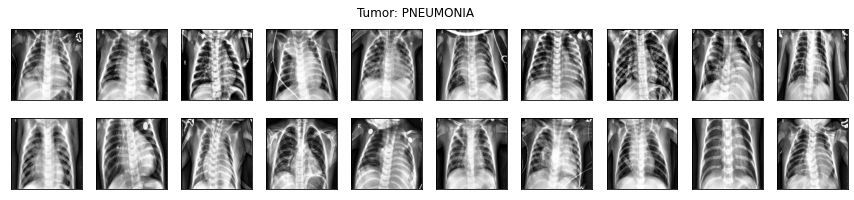

In [11]:
show_samples(train_images,train_labels,label_dict)

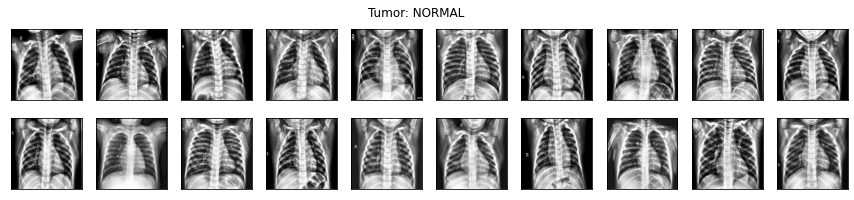

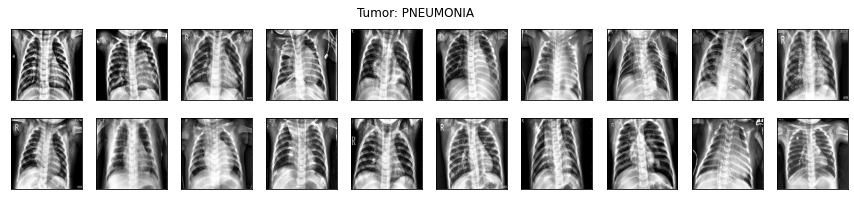

In [12]:
show_samples(val_images,val_labels,label_dict)

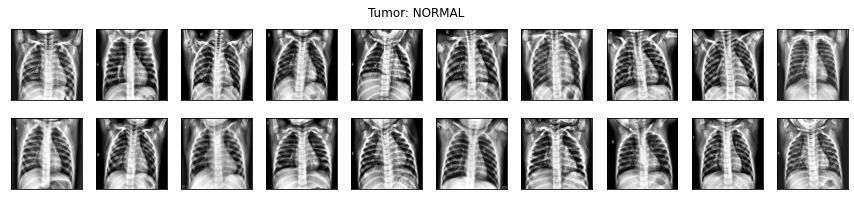

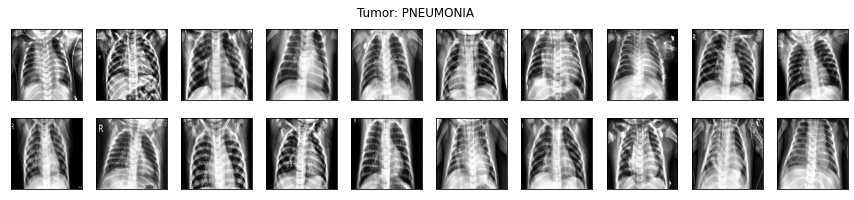

In [13]:
show_samples(test_images,test_labels,label_dict)

Since we have around 4k images in our training dataset, and since this task shouldn't need a complex CNN architecture, I skipped using data augmentation. Also, the dataset looks fairly similar in terms of scale, rotation, translation again deeming data augmentation not so important. However, if you want to use this for real-life testing, data augmentation could really boost such test accuracy.

# Model Selection

Logically speaking, as a human there don't seem to be many features that would be needed for classification. So, I considered using 2 Conv layers and 2 Fully Connected with layers. Now, there are many optimizations and hyperparameters that I was considering. In my opinion, regularization is something that has no harm if used even in places where it's not needed. This is a default optimization.

Along with this, I was skeptical about the boost in accuracy by using Dropout and Batch Normalization. So I'll try all 4 possibilities and in the end on the basis of validation set accuracy, I'll select the best model and evaluate its accuracy on test set.

Since, this is diagnosis of disease, we could have false positives (though undesirable), but we should not have very few false negatives. Thus, we give more weightage to Recall as compared to Precision. Thus, we also consider this metric while comparing the models.

In [14]:
models = []
histories = []
modelValResults = []

num_epochs = 40
batch_size = 32

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=8000,
    decay_rate=0.001)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [15]:
def recall_m(y_true,y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    pos = K.sum(K.round(K.clip(y_true, 0, 1)))
    return tp/(pos + K.epsilon())
def precision_m(y_true,y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predpos = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return tp/(predpos + K.epsilon())
def f1_score(y_true,y_pred):
    rec = recall_m(y_true,y_pred)
    prec = precision_m(y_true,y_pred)
    return 2 * (prec * rec) / (prec + rec)

## Model 1 - 2 CONV-Max Pooling Units and 2 FC layers

In [16]:
model = Sequential()

model.add(Conv2D(64,kernel_size=5,input_shape=(224,224,1),padding='same',kernel_regularizer='l2'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=3,padding='same',kernel_regularizer='l2'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4),strides=(4,4)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100,activation='relu',kernel_regularizer='l2'))
model.add(Dense(1,activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy',recall_m,f1_score]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1664      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0

In [17]:
history = model.fit(
    train_images,train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(val_images,val_labels)
)

Train on 5270 samples, validate on 292 samples
Epoch 1/40
5270/5270 [==============================] - 13s 2ms/sample - loss: 0.9175 - accuracy: 0.7230 - recall_m: 0.9899 - f1_score: nan - val_loss: 0.5246 - val_accuracy: 0.7911 - val_recall_m: 1.0000 - val_f1_score: 0.8794
Epoch 2/40
5270/5270 [==============================] - 8s 2ms/sample - loss: 0.5882 - accuracy: 0.7260 - recall_m: 1.0000 - f1_score: 0.8383 - val_loss: 0.5200 - val_accuracy: 0.7911 - val_recall_m: 1.0000 - val_f1_score: 0.8794
Epoch 3/40
5270/5270 [==============================] - 8s 1ms/sample - loss: 0.5877 - accuracy: 0.7260 - recall_m: 1.0000 - f1_score: 0.8388 - val_loss: 0.5146 - val_accuracy: 0.7911 - val_recall_m: 1.0000 - val_f1_score: 0.8794
Epoch 4/40
5270/5270 [==============================] - 8s 1ms/sample - loss: 0.5886 - accuracy: 0.7260 - recall_m: 1.0000 - f1_score: 0.8385 - val_loss: 0.5199 - val_accuracy: 0.7911 - val_recall_m: 1.0000 - val_f1_score: 0.8794
Epoch 5/40
5270/5270 [=============

In [18]:
models.append(model)
histories.append(history)
evaltn = [1] + model.evaluate(val_images,val_labels)
modelValResults.append(evaltn)
print(f'Model\'s Performance on Validation Set - Loss: {evaltn[1]}, Accuracy: {evaltn[2]}, Recall: {evaltn[3]}, F1-score: {evaltn[4]}')

292/292 [==============================] - 0s 610us/sample - loss: 0.5238 - accuracy: 0.7911 - recall_m: 1.0000 - f1_score: 0.8794
Model's Performance on Validation Set - Loss: 0.5237547379650481, Accuracy: 0.7910959124565125, Recall: 1.0, F1-score: 0.8794103860855103


In [19]:
model.save('pneumonia-1.h5')

## Model 2 - 2 Conv-Max Pooling-Dropout 2 FC Layers

In [20]:
model = Sequential()

model.add(Conv2D(64,kernel_size=5,input_shape=(224,224,1),padding='same',kernel_regularizer='l2'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=3,padding='same',kernel_regularizer='l2'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4),strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100,activation='relu',kernel_regularizer='l2'))
model.add(Dense(1,activation='sigmoid'))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=8000,
    decay_rate=0.001)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy',recall_m,f1_score]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 64)      1664      
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
activation_3 (Activation)    (None, 112, 112, 128)     0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 128)      

In [21]:
history = model.fit(
    train_images,train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(val_images,val_labels)
)

Train on 5270 samples, validate on 292 samples
Epoch 1/40
5270/5270 [==============================] - 9s 2ms/sample - loss: 0.9050 - accuracy: 0.7201 - recall_m: 0.9871 - f1_score: nan - val_loss: 0.5268 - val_accuracy: 0.7911 - val_recall_m: 1.0000 - val_f1_score: 0.8794
Epoch 2/40
5270/5270 [==============================] - 8s 2ms/sample - loss: 0.5890 - accuracy: 0.7260 - recall_m: 1.0000 - f1_score: 0.8391 - val_loss: 0.5243 - val_accuracy: 0.7911 - val_recall_m: 1.0000 - val_f1_score: 0.8794
Epoch 3/40
5270/5270 [==============================] - 8s 2ms/sample - loss: 0.5882 - accuracy: 0.7260 - recall_m: 1.0000 - f1_score: 0.8389 - val_loss: 0.5190 - val_accuracy: 0.7911 - val_recall_m: 1.0000 - val_f1_score: 0.8794
Epoch 4/40
5270/5270 [==============================] - 8s 2ms/sample - loss: 0.5884 - accuracy: 0.7260 - recall_m: 1.0000 - f1_score: 0.8381 - val_loss: 0.5217 - val_accuracy: 0.7911 - val_recall_m: 1.0000 - val_f1_score: 0.8794
Epoch 5/40
5270/5270 [==============

In [22]:
models.append(model)
histories.append(history)
evaltn = [2] + model.evaluate(val_images,val_labels)
modelValResults.append(evaltn)
print(f'Model\'s Performance on Validation Set - Loss: {evaltn[1]}, Accuracy: {evaltn[2]}, Recall: {evaltn[3]}, F1-score: {evaltn[4]}')

292/292 [==============================] - 0s 612us/sample - loss: 0.5238 - accuracy: 0.7911 - recall_m: 1.0000 - f1_score: 0.8794
Model's Performance on Validation Set - Loss: 0.5237540055627692, Accuracy: 0.7910959124565125, Recall: 1.0, F1-score: 0.8794103860855103


In [23]:
model.save('pneumonia-2.h5')

## Model 3 - 2 Conv-BatchNorm-MaxPooling-Dropout 2 FC Layers

In [24]:
model = Sequential()

model.add(Conv2D(64,kernel_size=5,input_shape=(224,224,1),padding='same',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=3,padding='same',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4),strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100,activation='relu',kernel_regularizer='l2'))
model.add(Dense(1,activation='sigmoid'))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=8000,
    decay_rate=0.001)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy',recall_m,f1_score]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 64)      1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
activation_4 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 128)    

In [25]:
history = model.fit(
    train_images,train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(val_images,val_labels)
)

Train on 5270 samples, validate on 292 samples
Epoch 1/40
5270/5270 [==============================] - 12s 2ms/sample - loss: 10.6054 - accuracy: 0.7888 - recall_m: 0.9221 - f1_score: nan - val_loss: 1.1074 - val_accuracy: 0.7911 - val_recall_m: 1.0000 - val_f1_score: 0.8794
Epoch 2/40
5270/5270 [==============================] - 10s 2ms/sample - loss: 0.6382 - accuracy: 0.8750 - recall_m: 0.9254 - f1_score: 0.9135 - val_loss: 0.7616 - val_accuracy: 0.8356 - val_recall_m: 1.0000 - val_f1_score: 0.9002
Epoch 3/40
5270/5270 [==============================] - 10s 2ms/sample - loss: 0.4374 - accuracy: 0.8915 - recall_m: 0.9354 - f1_score: 0.9248 - val_loss: 0.7911 - val_accuracy: 0.7911 - val_recall_m: 1.0000 - val_f1_score: 0.8794
Epoch 4/40
5270/5270 [==============================] - 10s 2ms/sample - loss: 0.3815 - accuracy: 0.8979 - recall_m: 0.9373 - f1_score: 0.9285 - val_loss: 0.7524 - val_accuracy: 0.7911 - val_recall_m: 1.0000 - val_f1_score: 0.8794
Epoch 5/40
5270/5270 [=========

In [26]:
models.append(model)
histories.append(history)
evaltn = [3] + model.evaluate(val_images,val_labels)
modelValResults.append(evaltn)
print(f'Model\'s Performance on Validation Set - Loss: {evaltn[1]}, Accuracy: {evaltn[2]}, Recall: {evaltn[3]}, F1-score: {evaltn[4]}')

292/292 [==============================] - 0s 711us/sample - loss: 0.2324 - accuracy: 0.9110 - recall_m: 0.9622 - f1_score: 0.9345
Model's Performance on Validation Set - Loss: 0.23237256644523308, Accuracy: 0.9109588861465454, Recall: 0.9621689915657043, F1-score: 0.9345425367355347


In [27]:
model.save('pneumonia-3.h5')

## Model 4 - 2 Conv-BatchNorm-MaxPooling 2 FC Layers

In [28]:
model = Sequential()

model.add(Conv2D(64,kernel_size=5,input_shape=(224,224,1),padding='same',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
# model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=3,padding='same',kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4),strides=(4,4)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100,activation='relu',kernel_regularizer='l2'))
model.add(Dense(1,activation='sigmoid'))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=8000,
    decay_rate=0.001)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy',recall_m,f1_score]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 64)      1664      
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
activation_6 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
activation_7 (Activation)    (None, 112, 112, 128)    

In [29]:
history = model.fit(
    train_images,train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(val_images,val_labels)
)

Train on 5270 samples, validate on 292 samples
Epoch 1/40
5270/5270 [==============================] - 11s 2ms/sample - loss: 7.5632 - accuracy: 0.8093 - recall_m: 0.9076 - f1_score: nan - val_loss: 1.1912 - val_accuracy: 0.7911 - val_recall_m: 1.0000 - val_f1_score: 0.8794
Epoch 2/40
5270/5270 [==============================] - 10s 2ms/sample - loss: 0.6534 - accuracy: 0.8926 - recall_m: 0.9351 - f1_score: 0.9246 - val_loss: 0.8152 - val_accuracy: 0.7979 - val_recall_m: 1.0000 - val_f1_score: 0.8825
Epoch 3/40
5270/5270 [==============================] - 10s 2ms/sample - loss: 0.4546 - accuracy: 0.9036 - recall_m: 0.9410 - f1_score: 0.9332 - val_loss: 0.6207 - val_accuracy: 0.7911 - val_recall_m: 1.0000 - val_f1_score: 0.8794
Epoch 4/40
5270/5270 [==============================] - 10s 2ms/sample - loss: 0.3575 - accuracy: 0.9156 - recall_m: 0.9447 - f1_score: 0.9406 - val_loss: 2.8072 - val_accuracy: 0.7911 - val_recall_m: 1.0000 - val_f1_score: 0.8794
Epoch 5/40
5270/5270 [==========

In [30]:
models.append(model)
histories.append(history)
evaltn = [4] + model.evaluate(val_images,val_labels)
modelValResults.append(evaltn)
print(f'Model\'s Performance on Validation Set - Loss: {evaltn[1]}, Accuracy: {evaltn[2]}, Recall: {evaltn[3]}, F1-score: {evaltn[4]}')

292/292 [==============================] - 0s 724us/sample - loss: 0.2465 - accuracy: 0.9075 - recall_m: 0.8994 - f1_score: 0.9129
Model's Performance on Validation Set - Loss: 0.24651611259538833, Accuracy: 0.9075342416763306, Recall: 0.8993524312973022, F1-score: 0.9129141569137573


In [31]:
model.save('pneumonia-4.h5')

# Compare Performances of 4 Models

In [32]:
pd.DataFrame(modelValResults,columns=['Model No','Validation Loss','Validation Accuracy','Recall','F1-Score'])

,Model No,Validation Loss,Validation Accuracy,Recall,F1-Score
0,1,0.523755,0.791096,1.000000,0.879410
1,2,0.523754,0.791096,1.000000,0.879410
2,3,0.232373,0.910959,0.962169,0.934543
3,4,0.246516,0.907534,0.899352,0.912914


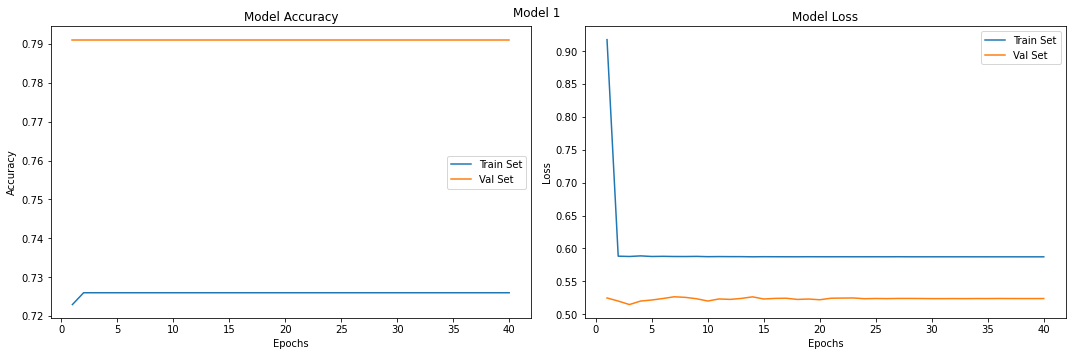

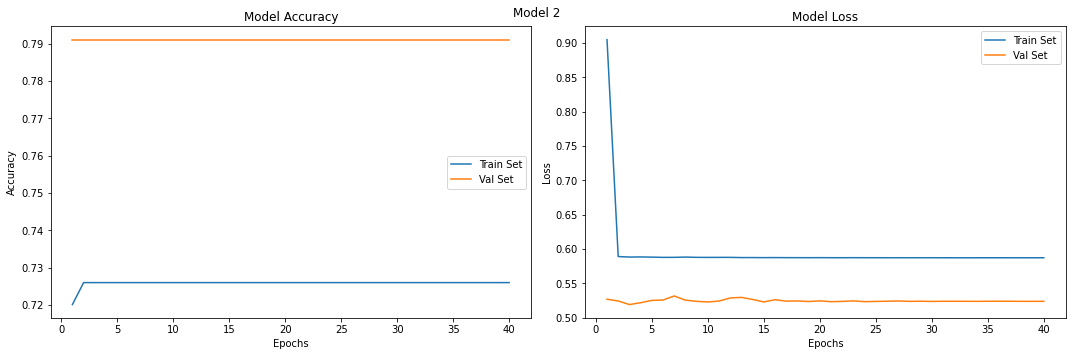

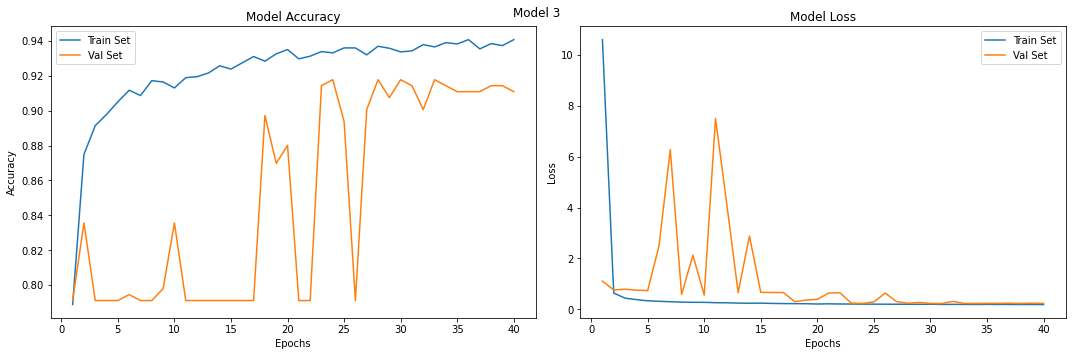

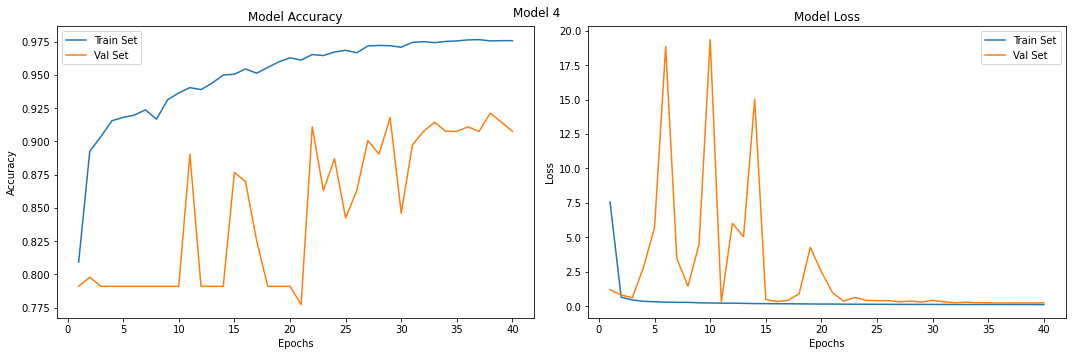

In [33]:
for i in range(len(histories)):
    history = histories[i]
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(history.epoch) + 1)

    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Set')
    plt.plot(epochs_range, val_acc, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Set')
    plt.plot(epochs_range, val_loss, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    
    plt.suptitle('Model '+str(i+1))

    plt.tight_layout()
    plt.show()

## View Details of Best Model based on Validation Accuracy

In [34]:
bestModelI = np.argmax(np.array(modelValResults)[:,2],axis=0)
history = histories[bestModelI]
print('On the basis of validation set accuracy, the best model seems to be Model ',(bestModelI+1))

On the basis of validation set accuracy, the best model seems to be Model  3


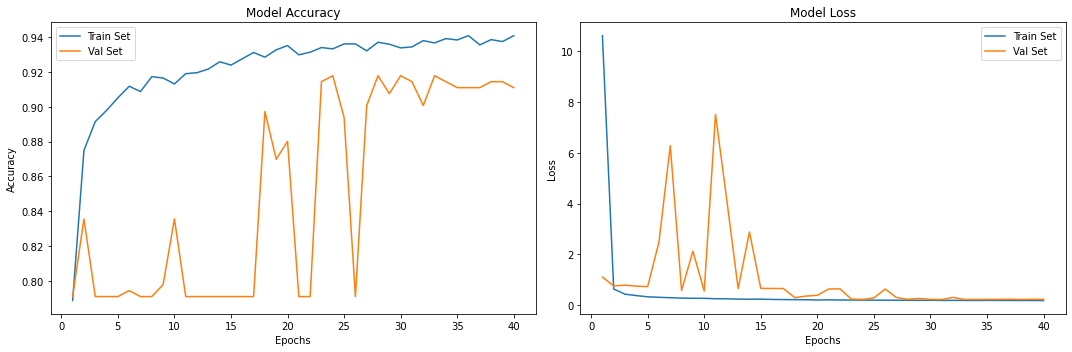

In [35]:
history = histories[bestModelI]
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Performance on Test Set

(array([0, 1]), array([ 72, 222]))
294/294 [==============================] - 0s 707us/sample - loss: 0.1969 - accuracy: 0.9456 - recall_m: 0.9673 - f1_score: 0.9589
Model's Performance on Test Set - Loss: 0.1969038102091575, Accuracy: 0.9455782175064087, Recall: 0.9672689437866211, F1-score: 0.9589419364929199


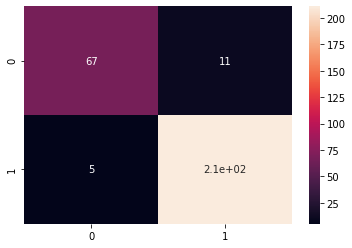

In [36]:
model = models[bestModelI]
preds = (model.predict(test_images) >= 0.5).astype(int)
sns.heatmap(confusion_matrix(test_labels,preds),annot=True)

print(np.unique(preds,return_counts=True))

# model.evaluate(test_images,OneHotEncoder().fit_transform(test_labels.reshape(1,-1)).toarray())
evaltn = model.evaluate(test_images,test_labels)
print(f'Model\'s Performance on Test Set - Loss: {evaltn[0]}, Accuracy: {evaltn[1]}, Recall: {evaltn[2]}, F1-score: {evaltn[3]}')

## View Details of Best Model based on Recall

In [37]:
bestModelI = np.argmax(np.array(modelValResults)[:,3],axis=0)
history = histories[bestModelI]
print('On the basis of recall, the best model seems to be Model ',(bestModelI+1))

On the basis of recall, the best model seems to be Model  1


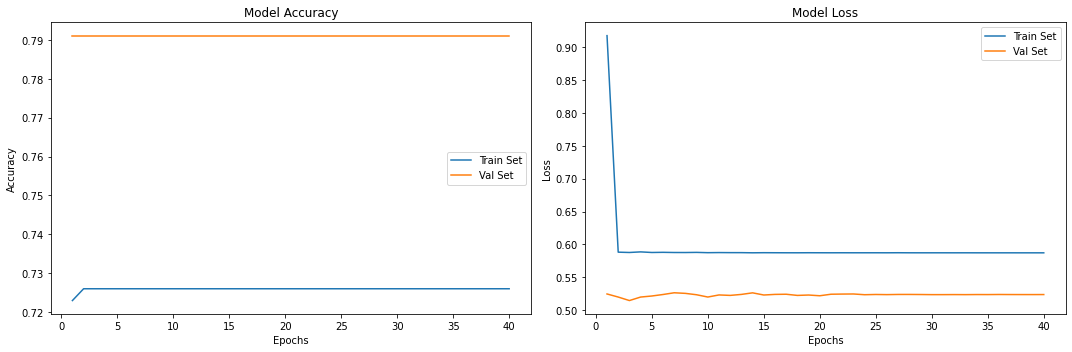

In [38]:
history = histories[bestModelI]
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Performance on Test Set

(array([1]), array([294]))
294/294 [==============================] - 0s 577us/sample - loss: 0.5787 - accuracy: 0.7347 - recall_m: 1.0000 - f1_score: 0.8564
Model's Performance on Test Set - Loss: 0.5787238831422767, Accuracy: 0.7346938848495483, Recall: 1.0, F1-score: 0.8563821911811829


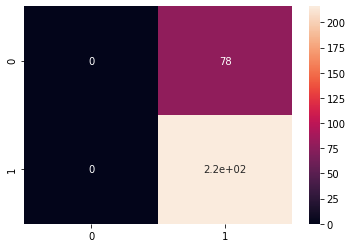

In [39]:
model = models[bestModelI]
preds = (model.predict(test_images) >= 0.5).astype(int)
sns.heatmap(confusion_matrix(test_labels,preds),annot=True)

print(np.unique(preds,return_counts=True))

# model.evaluate(test_images,OneHotEncoder().fit_transform(test_labels.reshape(1,-1)).toarray())
evaltn = model.evaluate(test_images,test_labels)
print(f'Model\'s Performance on Test Set - Loss: {evaltn[0]}, Accuracy: {evaltn[1]}, Recall: {evaltn[2]}, F1-score: {evaltn[3]}')

## View Details of Best Model based on F1-Score

In [40]:
bestModelI = np.argmax(np.array(modelValResults)[:,4],axis=0)
history = histories[bestModelI]
print('On the basis of F1-Score, the best model seems to be Model ',(bestModelI+1))

On the basis of F1-Score, the best model seems to be Model  3


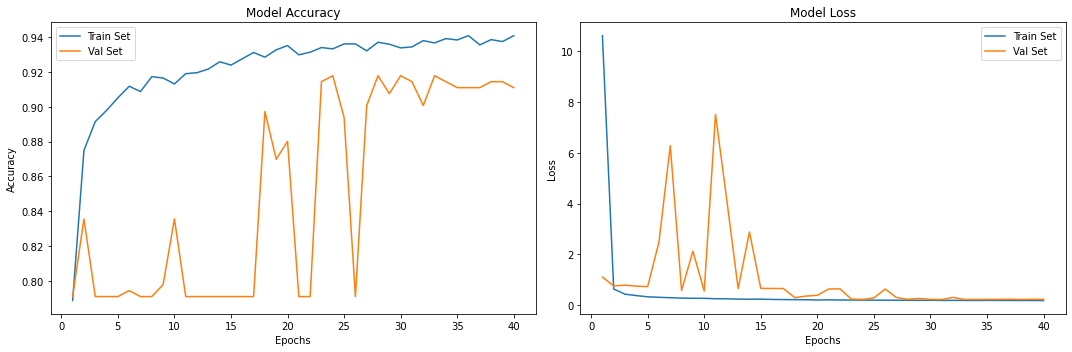

In [41]:
history = histories[bestModelI]
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Performance on Test Set

(array([0, 1]), array([ 72, 222]))
294/294 [==============================] - 0s 690us/sample - loss: 0.1969 - accuracy: 0.9456 - recall_m: 0.9673 - f1_score: 0.9589
Model's Performance on Test Set - Loss: 0.1969038102091575, Accuracy: 0.9455782175064087, Recall: 0.9672689437866211, F1-score: 0.9589419364929199


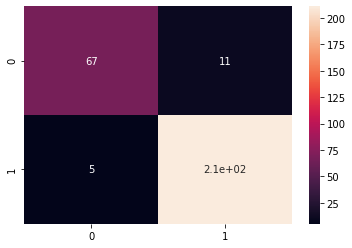

In [42]:
model = models[bestModelI]
preds = (model.predict(test_images) >= 0.5).astype(int)
sns.heatmap(confusion_matrix(test_labels,preds),annot=True)

print(np.unique(preds,return_counts=True))

# model.evaluate(test_images,OneHotEncoder().fit_transform(test_labels.reshape(1,-1)).toarray())
evaltn = model.evaluate(test_images,test_labels)
print(f'Model\'s Performance on Test Set - Loss: {evaltn[0]}, Accuracy: {evaltn[1]}, Recall: {evaltn[2]}, F1-score: {evaltn[3]}')